In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

In [2]:
plt.style.use(style='seaborn')

In [3]:
raw_data = yfinance.download(
                    tickers=["ICICIBANK.NS", "^NSEI", "^BSESN", "HDFCBANK.NS"],
                    start="2014-12-31",
                    group_by="ticker",
                    auto_adjust=True,
                    interval="1d",
                    treads=True
                    )

[*********************100%***********************]  4 of 4 completed


In [4]:
df = raw_data.copy()

In [5]:
df["bse"] = df["^BSESN"].Close
df["nse"] = df["^NSEI"].Close
df["icici"] = df["ICICIBANK.NS"].Close
df["hdfc"] = df["HDFCBANK.NS"].Close

del  df["^NSEI"], df["^BSESN"], df["ICICIBANK.NS"], df["HDFCBANK.NS"]
df.head()

,bse,nse,icici,hdfc
,,,,
Date,,,,
2014-12-31,27499.419922,8282.700195,300.588135,458.484467
2015-01-01,NaN,NaN,299.907104,458.701355
2015-01-02,27887.900391,8395.450195,308.419952,465.085205
2015-01-05,27842.320312,8378.400391,309.058350,461.158539
2015-01-06,26987.460938,8127.350098,295.948639,453.979614


In [6]:
df = df.asfreq("b")
df = df.fillna(method="bfill")

In [9]:
returns =["icici_ret", "nse_ret", "bse_ret", "hdfc_ret"]
df["nse_ret"] = df.nse.pct_change(1).mul(100)
df["bse_ret"] = df.bse.pct_change(1).mul(100)
df["icici_ret"] = df.icici.pct_change(1).mul(100)
df["hdfc_ret"]=df.hdfc.pct_change(1).mul(100)

In [8]:
df.head()

,bse,nse,icici,hdfc,nse_ret,bse_ret,icici_ret,hdfc_ret
,,,,,,,,
Date,,,,,,,,
2014-12-31,27499.419922,8282.700195,300.588135,458.484467,NaN,NaN,NaN,NaN
2015-01-01,27887.900391,8395.450195,299.907104,458.701355,1.361271,1.412686,-0.226566,0.047306
2015-01-02,27887.900391,8395.450195,308.419952,465.085205,0.000000,0.000000,2.838495,1.391723
2015-01-05,27842.320312,8378.400391,309.058350,461.158539,-0.203084,-0.163440,0.206990,-0.844290
2015-01-06,26987.460938,8127.350098,295.948639,453.979614,-2.996399,-3.070360,-4.241824,-1.556715


In [13]:
size = int(len(df)*0.8)
df_train, df_test = df.iloc[:size], df.iloc[size:]

In [16]:
df_train.tail()

,bse,nse,icici,hdfc,nse_ret,bse_ret,icici_ret,hdfc_ret
,,,,,,,,
Date,,,,,,,,
2019-11-28,41130.171875,12151.150391,519.150024,1265.300049,0.416920,0.267091,2.700302,-1.024716
2019-11-29,40793.808594,12056.049805,512.599976,1274.949951,-0.782647,-0.817802,-1.261687,0.762657
2019-12-02,40802.171875,12048.200195,510.899994,1265.750000,-0.065109,0.020501,-0.331639,-0.721593
2019-12-03,40675.449219,11994.200195,509.350006,1255.400024,-0.448200,-0.310578,-0.303384,-0.817695
2019-12-04,40850.289062,12043.200195,529.250000,1251.650024,0.408531,0.429841,3.906939,-0.298710


In [17]:
df_test.tail()

,bse,nse,icici,hdfc,nse_ret,bse_ret,icici_ret,hdfc_ret
,,,,,,,,
Date,,,,,,,,
2021-02-22,49744.320312,14675.700195,609.849976,1548.000000,-2.042817,-2.250829,-2.275461,0.578262
2021-02-23,49751.410156,14707.799805,616.299988,1529.150024,0.218726,0.014253,1.057639,-1.217699
2021-02-24,50781.691406,14982.000000,641.099976,1606.449951,1.864318,2.070858,4.024012,5.055091
2021-02-25,51039.308594,15097.349609,628.000000,1606.400024,0.769921,0.507303,-2.043359,-0.003108
2021-02-26,49099.988281,14529.150391,597.750000,1534.400024,-3.763569,-3.799660,-4.816879,-4.482072


In [52]:
model_auto = auto_arima(df_train.icici_ret[1:], exogenous = df_train[["nse_ret", "bse_ret", "hdfc_ret"]][1:],
                       m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)

In [18]:
start_date = "2019-12-05"
end_date = "2021-01-01"

In [19]:
df_auto_pred = pd.DataFrame(model_auto.predict(n_periods = len(df_test[start_date:end_date]),
                            exogenous = df_test[["nse_ret", "bse_ret", "hdfc_ret"]][start_date:end_date]),
                            index = df_test[start_date:end_date].index)

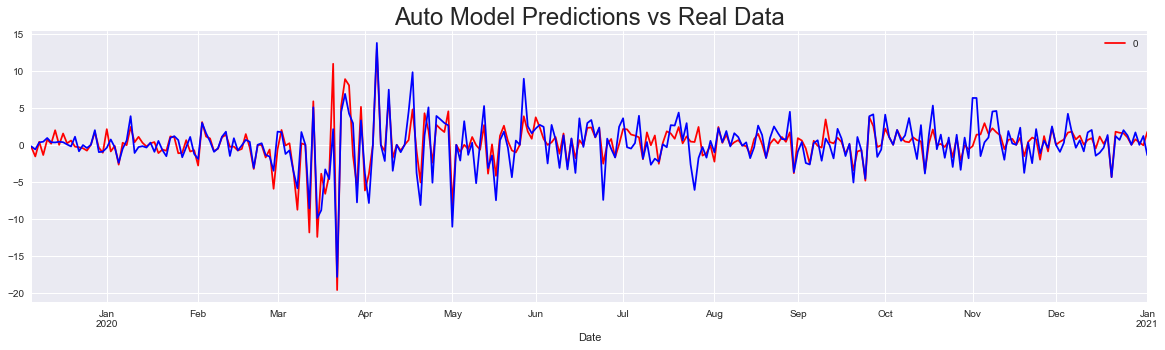

In [20]:
df_auto_pred.plot(figsize = (20,5), color = "red")
df_test.icici_ret[start_date:end_date].plot(color = "blue")
plt.title("Auto Model Predictions vs Real Data", size = 24)
plt.show()

In [50]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                   
====================================================================================
Dep. Variable:                            y   No. Observations:                 1285
Model:             SARIMAX(0, 0, [1, 2], 5)   Log Likelihood               -2280.979
Date:                      Fri, 26 Feb 2021   AIC                           4573.957
Time:                              21:56:29   BIC                           4604.908
Sample:                          01-01-2015   HQIC                          4585.577
                               - 12-04-2019                                         
Covariance Type:                        opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
nse_ret       -0.8211      0.345     -2.379      0.017      -1.497      -0.145
bse_ret        2.6461      0.335      7.891      0.000       1.989       3.303
hdfc_ret      -0.3581      0.037     -9.669      0.000      -0.431      -0.286
ma.S.L5       -0.0569      0.025     -2.318      0.020      -0.105      -0.009
ma.S.L10      -0.0493      0.028     -1.777      0.076      -0.104       0.005
sigma2         2.0386      0.054     37.574      0.000       1.932       2.145
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1360.40
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.86
Prob(H) (two-sided):                  0.68   Kurtosis:                         7.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [53]:
model_auto_p = auto_arima(df_train.icici[1:], exogenous = df_train[["nse", "bse", "hdfc"]][1:],
                       m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)

In [54]:
model_auto_p.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1285
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3651.813
Date:                Fri, 26 Feb 2021   AIC                           7311.626
Time:                        22:01:19   BIC                           7332.257
Sample:                    01-01-2015   HQIC                          7319.371
                         - 12-04-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
nse           -0.0219      0.009     -2.354      0.019      -0.040      -0.004
bse            0.0229      0.003      8.356      0.000       0.018       0.028
hdfc          -0.0990      0.009    -10.779      0.000      -0.117      -0.081
sigma2        17.2923      0.413     41.890      0.000      16.483      18.101
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):              1317.20
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               2.33   Skew:                             0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [59]:
df_auto_pred_p= pd.DataFrame(model_auto_p.predict(n_periods = len(df_test[start_date:end_date]),
                            exogenous = df_test[["nse", "bse", "hdfc"]][start_date:end_date]),
                            index = df_test[start_date:end_date].index)

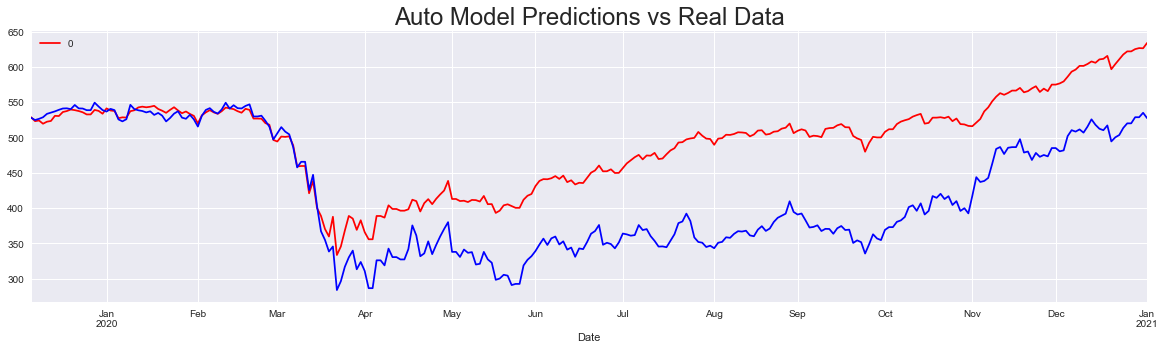

In [60]:
df_auto_pred_p.plot(figsize = (20,5), color = "red")
df_test.icici[start_date:end_date].plot(color = "blue")
plt.title("Auto Model Predictions vs Real Data", size = 24)
plt.show()

In [61]:
df_auto_pred_2= pd.DataFrame(model_auto_p.predict(n_periods = len(df_test[end_date:]),
                            exogenous = df_test[["nse", "bse", "hdfc"]][end_date:]),
                            index = df_test[end_date:].index)

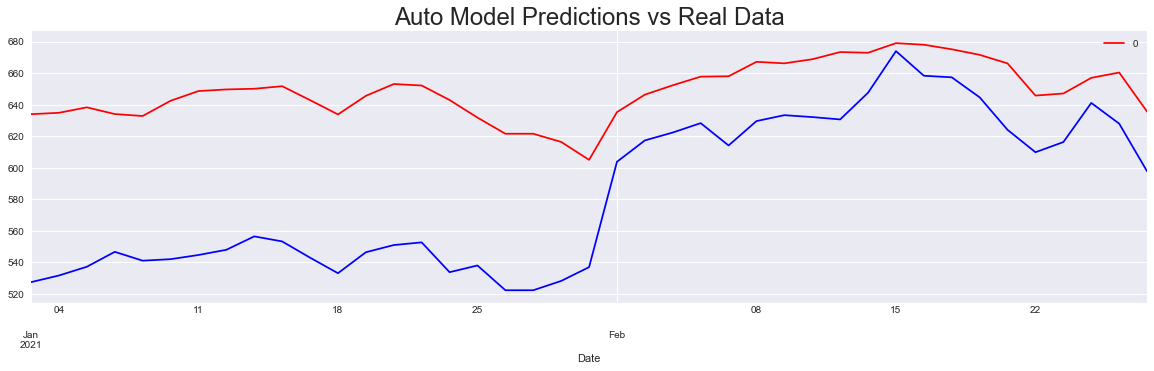

In [62]:
df_auto_pred_2.plot(figsize = (20,5), color = "red")
df_test.icici[end_date:].plot(color = "blue")
plt.title("Auto Model Predictions vs Real Data", size = 24)
plt.show()

In [74]:
model1 = arch_model(df.icici_ret[1:],
                    mean="constant",
                    vol="GARCH",
                    p=1,
                    q=1,
                    dist="Normal")
results1 = model1.fit(last_obs= start_date, update_freq=10)
results1.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2658.296288640122
            Iterations: 8
            Function evaluations: 51
            Gradient evaluations: 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              icici_ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2658.30
Distribution:                  Normal   AIC:                           5324.59
Method:            Maximum Likelihood   BIC:                           5345.23
                                        No. Observations:                 1285
Date:                Fri, Feb 26 2021   Df Residuals:                     1284
Time:                        22:14:36   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0801  5.333e-02      1.502      0.133 [-2.443e-02,  0.185]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.3910      0.207      1.893  5.837e-02  [-1.386e-02,  0.796]
alpha[1]       0.0429  2.010e-02      2.134  3.281e-02 [3.506e-03,8.228e-02]
beta[1]        0.8526  5.675e-02     15.023  5.162e-51     [  0.741,  0.964]
============================================================================

Covariance estimator: robust
"""

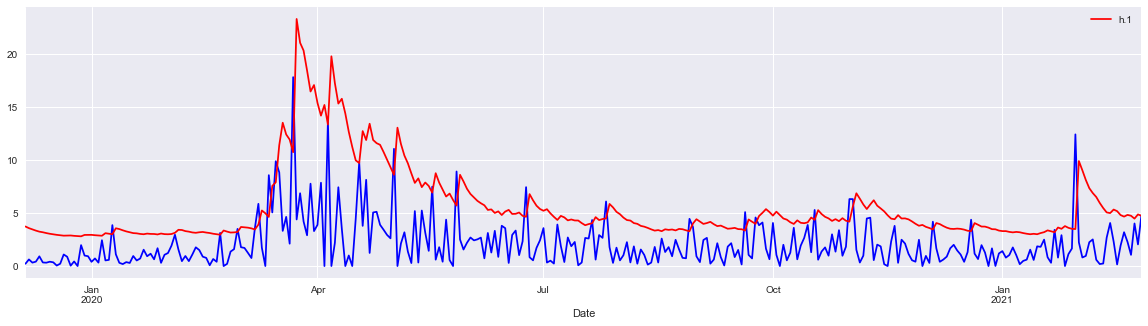

In [76]:
pred_garch = results1.forecast(horizon=1, align="target")
pred_garch.residual_variance[start_date:].plot(figsize = (20,5), color='red', zorder=2)
df_test.icici_ret[start_date:].abs().plot(color='blue',zorder=1)
plt.show()